In [1]:
import pymmmc

import aesara.tensor as at
import numpy as np
import pandas as pd

from aesara.tensor import TensorVariable

import pymc as pm

import matplotlib.pyplot as plt
import arviz as az

In [2]:
rng = np.random.RandomState(seed=34)
T = 10
T0 = 0

# individual-level model
lam = 0.5; p = 0.3

# random chosen individual model
a = b = alpha = r = 2

size = (5, 3)

In [3]:
data = pymmmc.distributions.continuous_non_contractual.rng_fn(rng, lam, p, T, T0, size=[1000,])

In [4]:
def moment(T, lam, p):
    return np.exp(-lam*T)*(T**2)/2*(1 + lam/(1 - (1 - p)*lam)) - (T*np.exp(-lam*T)*p - p*np.exp(-lam*T)/lam - lam*p)/(1 - (1 - p)*lam)

In [5]:
with pm.Model() as model:

    λ = pm.Gamma(name="λ", alpha=0.1, beta=0.1)
    π = pm.Beta(name="π", alpha=1, beta=1)
    
    clv = pymmmc.ContNonContract(
        name="individual-level-clv",
        lam=λ,
        p=π,
        T=10,
        T0=0,
        observed=data,
    )
    
    trace = pm.sample(draws=30000, chains=1, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [λ, π]


Sampling 1 chain for 5_000 tune and 30_000 draw iterations (5_000 + 30_000 draws total) took 19 seconds.


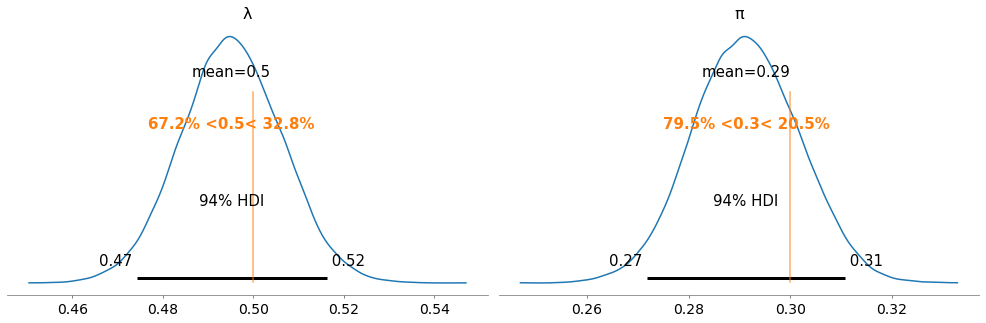

In [6]:
_ = az.plot_posterior(trace, ref_val=[0.5, 0.3])
plt.tight_layout()

In [24]:
def logp(value, lam, p, T, T0):
    t_x = value[..., 0]
    x = value[..., 1]
    
    A = x * np.log(1 - p) + x * np.log(lam) - lam * (T - T0)
    B = np.log(p) + (x - 1) * np.log(1 - p) + x * np.log(lam) - lam * (t_x - T0)
    
    return np.log(np.exp(A) + np.exp(B))

In [25]:
value = np.array([6.3, 5])
value[..., 0]

array(6.3)

In [26]:
tests = [
    (np.array([6.3, 5]), 0.4, 0.15, 12, 2),
    (np.array([6.3, 5]), np.array([0.3, 0.2]), 0.15, 12, 2),
    (np.array([[6.3, 5], [5.3, 4]]), np.array([0.3, 0.2]), 0.15, 12, 2),
    (np.array([6.3, 5]), 0.3, np.full((5, 3), 0.15), 12, 2),
]

for test in tests:
    print(logp(*test))

-8.39147106159807
[ -9.15153637 -10.42037984]
[-9.15153637 -8.57264195]
[[-9.15153637 -9.15153637 -9.15153637]
 [-9.15153637 -9.15153637 -9.15153637]
 [-9.15153637 -9.15153637 -9.15153637]
 [-9.15153637 -9.15153637 -9.15153637]
 [-9.15153637 -9.15153637 -9.15153637]]


In [27]:
with pm.Model():
    crc = pymmmc.ContNonContract("crc", lam, p, T, T0)

pm.logp(crc, np.array([6.3, 5])).eval()

array(-8.9338728)